In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd

InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

# GAS Model

In [ ]:
# del x0, x, y, x1, f_est
%whos ndarray DataFrame


In [ ]:
dat0 = pd.read_csv('ch4k_df_eu.csv', low_memory = False, index_col = 0)

In [ ]:
dat0.reset_index(inplace = True)
dat0.head()


In [ ]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    if  (alpha>0) and (sigma>0) and (beta>alpha) :
        f = filterGAS(y, x, parameters) 
        ll = np.zeros((len(y), 1))
        m=len(y)
        
        for t in range(0, len(y)):
             ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
        loglik_res = -(np.sum(ll))/m
        
    else:
        loglik_res=10**9

    return loglik_res

### Estimate a GAS model

In [ ]:
y = dat.net_qty.values # observed demand -- basically the response variable
x = dat.buy_availability.values # basically the explanatory variable

y = y.reshape((len(y),1)) 
x = x.reshape((len(y),1))

In [ ]:
import scipy

x0 = np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]) # starting value for optimisation
            # alpha, beta, omega, sigma, f0
            # See initialize_parameters for ordering

res = scipy.optimize.minimize(loglikest, # function to minimize log likelihood of observed values given parameters
                              x0,        # initial parameter values (starting)
                              args=(y, x), 
                                  # y1: obs demand
                                  # x: buy_availability
                              options ={'eps':1e-09},
                              method='L-BFGS-B', 
                              bounds=((0,  1),                # alpha
                                      (-0.99, 0.99),          # beta
                                      (0.001, np.mean(y)*2), # omega 
                                      (0.001, 1),             # sigma
                                      (0.001, np.mean(y)*2)  # f
                                     )
                             ) #restrictions in parameter space

x1 = res.x # numpy.ndarray, (5,)


In [ ]:
# Get estimated parameters and filter out the demand

x1par = initialize_parameters(res.x)
f_est = filterGAS(y, x, x1par)

In [ ]:
d = pd.DataFrame({'Obs_demand': y[:,0], 'Est_true_demand': f_est[:,0]})

# total real demand
round(np.sum(f_est))

# total observed demand
np.sum(y)

pd.DataFrame(data = d).plot(linewidth = 4)
# plt.ylim(0, 1200)
plt.title('Observed & Estimated Gross Demand Quantity')

pd.DataFrame(x).plot(linewidth = 4)
plt.title('Buy Availability')
#plt.ylabel('Real Data')


# Applied

In [ ]:
def GAS_est(y, x):
    # y: observed demand
    # x: buy_availability
    
    y = y.values
    x = x.values
    
    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    x0 = np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]) # # initial parameter values (starting)
    
    res = scipy.optimize.minimize(
        loglikest, # function to minimize (log likelihood y|x,theta)
        x0,        
        args=(y, x), 
        # y1: obs demand
        # x: buy_availability
        options ={'eps':1e-09},
        method='L-BFGS-B', 
        bounds=((0,  1),                # alpha
                (-0.99, 0.99),          # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, 1),             # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    x1par = initialize_parameters(res.x) 
    f_est = filterGAS(y, x, x1par)
    
    return f_est[:,0]
    

In [ ]:
dat = dat0.copy()
dat = dat[(dat.season == 'SS19') & (dat.country == 'EU')]

dat.sort_values(['article_number', 'year', 'month', 'week'], inplace = True)
dat.set_index('article_number', inplace = True)

In [ ]:
dat_samp1 = dat.loc[np.random.choice(dat.index, size = 1),:]
f_est1 = GAS_est(dat_samp1.net_qty, dat_samp1.buy_availability) # numpy.ndarray, (27, 1)

In [ ]:
f_est1.shape
type(f_est)

In [ ]:
dictEst = {}

In [ ]:
dictEst[np.random.choice(dat.index, size = 1).item()] = f_est1.reshape(f_est1.shape[0],).tolist()

In [ ]:
dictEst

pd.DataFrame(dictEst)

In [518]:
%%time

dat_samp2 = dat.loc[np.random.choice(dat.index, size = 50),:]
a = dat_samp2.groupby(dat_samp2.index).apply(lambda df: GAS_est(df['net_qty'], df['buy_availability']))

CPU times: user 7.77 s, sys: 102 ms, total: 7.87 s
Wall time: 7.82 s


In [519]:
d = a.to_dict()
wtf = pd.DataFrame()

for k in d.keys():
    df = pd.DataFrame(data = d[k], index = [k] * d[k].shape[0], columns = ['f_est'])
    wtf = wtf.append(df)

In [521]:
# dat_samp2.groupby(dat_samp2.index)['net_qty'].count()
# wtf.groupby(wtf.index)['f_est'].count()

In [522]:
dat_samp2.sort_index(inplace = True)
wtf.sort_index(inplace = True)
fme = pd.concat([dat_samp2, wtf], axis = 1)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


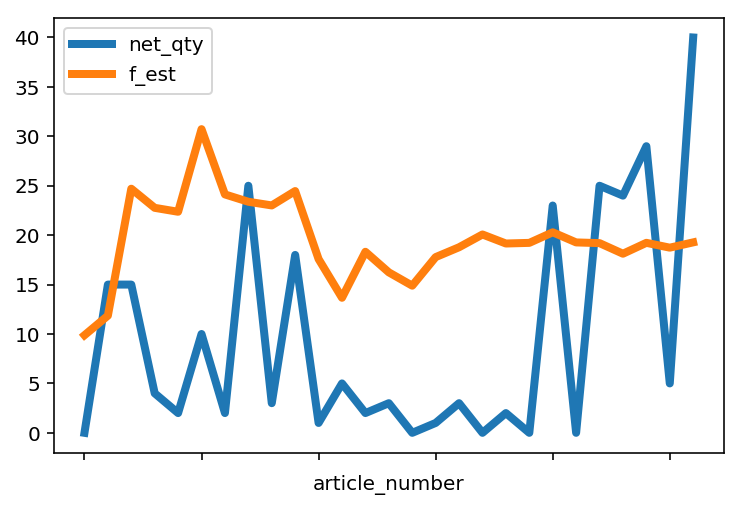

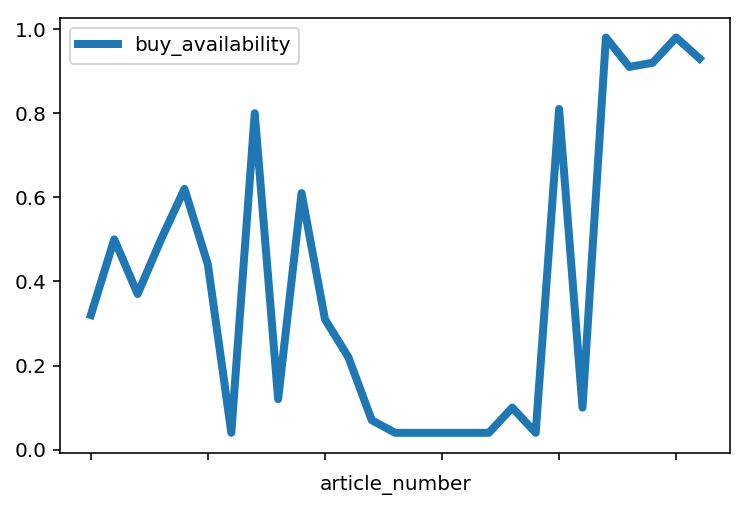

In [536]:
plt = fme.loc[np.random.choice(fme.index, size = 1),:]
plt1 = plt[['net_qty', 'f_est']]

plt1.plot(linewidth = 4)

pd.DataFrame(plt['buy_availability']).plot(linewidth = 4)

In [526]:
dat_samp = dat.loc[np.random.choice(dat.index, size = 1),:]
dat_samp.head()
f_est = GAS_est(dat_samp.net_qty, dat_samp.buy_availability)

d = pd.DataFrame({'Obs_demand': dat_samp.net_qty, 'Est_true_demand': f_est[:,0]})

# total real demand
round(np.sum(f_est))

# total observed demand
np.sum(dat_samp.net_qty)

pd.DataFrame(data = d).plot(linewidth = 4)
# plt.ylim(0, 1200)
plt.title('Observed & Estimated Gross Demand Quantity')

pd.DataFrame(dat_samp.buy_availability).plot(linewidth = 4)
plt.title('Buy Availability')
#plt.ylabel('Real Data')

,brand,year,week,country,season,month,gross_demand_quantity,net_qty,clearance,cost_of_sales,margin,season_gross_demand_quantity,season_net_qty,buy_availability,cost
article_number,,,,,,,,,,,,,,,
CM9169,reebok,2018,49,EU,SS19,12,1,1,0.0,23.706250,55.57,351,299,0.12,23.71
CM9169,reebok,2018,50,EU,SS19,12,2,1,0.0,23.755833,63.68,351,299,0.23,23.76
CM9169,reebok,2018,51,EU,SS19,12,7,7,0.0,23.855000,46.98,351,299,0.14,23.86
CM9169,reebok,2019,1,EU,SS19,1,1,1,1.0,23.920000,41.86,351,299,0.00,23.92
CM9169,reebok,2019,2,EU,SS19,1,7,5,1.0,23.878750,46.34,351,299,0.01,23.88


IndexError: too many indices for array